#  0. Import Libraries

In [2]:
# Import necessary libraries for data manipulation, visualization, and modeling

import pandas as pd
import xgboost as xgb

import pycaret
import sklearn

#Setting for ease of reading display numbers
pd.options.display.float_format = '{:20.2f}'.format

#Show all columns on output
pd.set_option('display.max_columns', 999)

# 1. Import Data

In [4]:
# Load the dataset from a CSV file

orig_df = pd.read_csv('../Datasets/ECommerce_Transactions_CLV.csv')

# Load the dataset from a CSV file

orig_df.head(10)

,CustomerID,OrderID,ProductID,InvoiceDate,Quantity,UnitPrice
0,cust2375,26984851472,1004906,2024-1-03T16:31:00Z,1,1.39
1,cust2375,26984851472,1033142,2024-1-03T16:31:00Z,1,0.82
2,cust2375,26984851472,1036325,2024-1-03T16:31:00Z,1,0.99
3,cust2375,26984851472,1082185,2024-1-03T16:31:00Z,1,1.21
4,cust2375,26984851472,8160430,2024-1-03T16:31:00Z,1,1.50
5,cust2375,26984851516,826249,2024-1-03T16:42:00Z,2,1.98
6,cust2375,26984851516,1043142,2024-1-03T16:42:00Z,1,1.57
7,cust2375,26984851516,1085983,2024-1-03T16:42:00Z,1,2.99
8,cust2375,26984851516,1102651,2024-1-03T16:42:00Z,1,1.89
9,cust2375,26984851516,6423775,2024-1-03T16:42:00Z,1,2.00


# 2. Data Exploration

In [6]:
# Show columns, data types, and nulls to prepare hygiene activities

orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   CustomerID   1048575 non-null  object 
 1   OrderID      1048575 non-null  int64  
 2   ProductID    1048575 non-null  int64  
 3   InvoiceDate  1048575 non-null  object 
 4   Quantity     1048575 non-null  int64  
 5   UnitPrice    1048575 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 48.0+ MB


In [7]:
# Show descriptive statistics for quantitative columns

orig_df.describe()

,OrderID,ProductID,Quantity,UnitPrice
count,1048575.00,1048575.00,1048575.00,1048575.00
mean,29735571272.90,2388947.40,94.43,3.06
std,1332620672.07,3036772.41,1113.84,4.02
min,26984851472.00,25671.00,0.00,0.00
25%,28601525437.00,913598.00,1.00,1.29
50%,29712832691.00,1019722.00,1.00,2.00
75%,30943091833.00,1120085.00,1.00,3.47
max,31884127672.00,13513242.00,85055.00,505.00


In [8]:
# Show descriptive statistics for quantitative columns

df = orig_df.copy()

In [9]:
# Convert 'InvoiceDate' to the correct format for time-based analysis

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
# Convert 'InvoiceDate' to the correct format for time-based analysis

df['Sales'] = df['Quantity']*df['UnitPrice']

In [11]:
df['Sales'].sum()

2979736092.5700006

In [12]:
# Define constants

profit_margin = 0.18
customer_lifetime = 3
eps_churn_rate = 0.001

In [13]:
# Create a column to represent the first purchase month for each 'CustomerID'

df['start_month'] = df.groupby('CustomerID')['InvoiceDate'].transform(lambda x: x.min().strftime('%Y-%m'))

# 3. Predictive Modeling

import pycaret.classification as clf
import pycaret.regression as reg

In [18]:
# Define constant

profit_margin = 0.18

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype              
---  ------       --------------    -----              
 0   CustomerID   1048575 non-null  object             
 1   OrderID      1048575 non-null  int64              
 2   ProductID    1048575 non-null  int64              
 3   InvoiceDate  1048575 non-null  datetime64[ns, UTC]
 4   Quantity     1048575 non-null  int64              
 5   UnitPrice    1048575 non-null  float64            
 6   Sales        1048575 non-null  float64            
 7   start_month  1048575 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(2)
memory usage: 64.0+ MB


### Feature Engineering

In [21]:
# Define a "cut-off date" for analyzing customer activity

n_days = 90
max_date = df['InvoiceDate'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit = 'D')

In [22]:
# Split the dataset into training (temporal_in_df) and validation (temporal_out_df) data

temporal_in_df = df[df['InvoiceDate'] < cutoff]

temporal_out_df = df[df['InvoiceDate'] >= cutoff].query('CustomerID in @temporal_in_df.CustomerID')

In [23]:
# Create a target dataset for validating CLV predictions

targets_df = temporal_out_df[['CustomerID','Sales']].groupby('CustomerID').sum().rename(columns={'Sales': 'Sales_90d'}).assign(sales_90_flag = 1)

In [24]:
targets_df

,Sales_90d,sales_90_flag
CustomerID,,
cust1,726.58,1
cust100,241.44,1
cust1000,843.11,1
cust1001,54.85,1
cust1002,6.78,1
...,...,...
cust995,82.43,1
cust996,557.67,1
cust997,950.44,1


In [25]:
# Compute "recency" features for each customer based on their last purchase date

max_date = temporal_in_df['InvoiceDate'].max()

recency_features_df = temporal_in_df[['CustomerID', 'InvoiceDate']].groupby('CustomerID').apply(
    lambda x: int((x['InvoiceDate'].max() - max_date) / pd.to_timedelta(1, 'day'))
    ).to_frame().set_axis(['recency'], axis=1)

In [26]:
recency_features_df

,recency
CustomerID,
cust1,-4
cust10,-99
cust100,-18
cust1000,-12
cust1001,-9
...,...
cust995,-5
cust996,-1
cust997,-3


In [27]:
# Compute "frequency" for each customer

frequency_features_df = temporal_in_df[['CustomerID','InvoiceDate']].groupby('CustomerID').count().set_axis(['frequency'], axis=1)

In [28]:
frequency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2495 entries, cust1 to cust999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   frequency  2495 non-null   int64
dtypes: int64(1)
memory usage: 39.0+ KB


In [29]:
# Compute "monetary value" for each customer

monetary_features_df = temporal_in_df.groupby('CustomerID').aggregate(
    {'Sales': ['sum','mean']}
).set_axis(['sales_value_sum', 'sales_value_mean'], axis=1)

In [30]:
monetary_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2495 entries, cust1 to cust999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sales_value_sum   2495 non-null   float64
 1   sales_value_mean  2495 non-null   float64
dtypes: float64(2)
memory usage: 58.5+ KB


In [31]:
temporal_in_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686258 entries, 0 to 698542
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   CustomerID   686258 non-null  object             
 1   OrderID      686258 non-null  int64              
 2   ProductID    686258 non-null  int64              
 3   InvoiceDate  686258 non-null  datetime64[ns, UTC]
 4   Quantity     686258 non-null  int64              
 5   UnitPrice    686258 non-null  float64            
 6   Sales        686258 non-null  float64            
 7   start_month  686258 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(2)
memory usage: 47.1+ MB


In [32]:
# Compute the number of transactions in the last month (4 weeks)

cutoff_28d = cutoff - pd.to_timedelta(28, unit = 'D')

transactions_last_month_df = temporal_in_df[['CustomerID','InvoiceDate']].drop_duplicates().query('InvoiceDate >= @cutoff_28d').groupby('CustomerID').size().to_frame().set_axis(['transactions_last_month'], axis=1)

In [33]:
# Compute the total sales value in the last month

sales_last_month_df = temporal_in_df[['CustomerID','InvoiceDate','Sales']].drop_duplicates().query('InvoiceDate >= @cutoff_28d').groupby('CustomerID').sum('Sales').set_axis(['sales_value_28d'], axis=1)

In [34]:
# Create the final feature set for CLV prediction by combining multiple customer behavior metrics 

features_df = pd.concat([recency_features_df, frequency_features_df, monetary_features_df, transactions_last_month_df, sales_last_month_df], axis=1).merge(targets_df,
       left_index=True,
       right_index=True,
       how= "left"
      ).fillna(0)

In [35]:
features_df

,recency,frequency,sales_value_sum,sales_value_mean,transactions_last_month,sales_value_28d,Sales_90d,sales_90_flag
CustomerID,,,,,,,,
cust1,-4,445,1464.05,3.29,4.00,189.46,726.58,1.00
cust10,-99,44,211.51,4.81,0.00,0.00,0.00,0.00
cust100,-18,164,648.79,3.96,2.00,49.86,241.44,1.00
cust1000,-12,389,1122236.60,2884.93,3.00,55.13,843.11,1.00
cust1001,-9,254,1841.10,7.25,3.00,150.52,54.85,1.00
...,...,...,...,...,...,...,...,...
cust995,-5,194,696.65,3.59,2.00,204.89,82.43,1.00
cust996,-1,210,89506.20,426.22,2.00,75.04,557.67,1.00
cust997,-3,410,1774.78,4.33,2.00,130.96,950.44,1.00


### XGBoost Classification

In [37]:
from pycaret.classification import *

In [38]:
# Convert 'sales_90_flag' column into an integer for classification modeling

features_df['sales_90_flag'] = features_df['sales_90_flag'].astype(float).astype(int)

In [39]:
# Setup the XGBoost Classification Model using PyCaret

clf = setup(
    data = features_df.drop('Sales_90d', axis = 1),
    target = 'sales_90_flag',
    train_size = 0.9,
    session_id = 42,
    verbose = True,
    log_experiment = False,
    fix_imbalance = True
)

,Description,Value
0,Session id,42
1,Target,sales_90_flag
2,Target type,Binary
3,Original data shape,"(2495, 7)"
4,Transformed data shape,"(4340, 7)"
5,Transformed train set shape,"(4090, 7)"
6,Transformed test set shape,"(250, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [40]:
# Train the XGBoost Classification Model to predict CLV

xgb_clf_model = clf.create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8800,0.8629,0.9122,0.9541,0.9327,0.3842,0.3925
1,0.8756,0.8629,0.9122,0.9492,0.9303,0.3492,0.3554
2,0.8622,0.8232,0.9073,0.9394,0.9231,0.2654,0.2691
3,0.8933,0.8562,0.9317,0.9502,0.9409,0.3960,0.3980
4,0.8667,0.9041,0.8927,0.9581,0.9242,0.3744,0.3915
5,0.8705,0.8988,0.8873,0.9679,0.9258,0.4245,0.4510
6,0.8348,0.8213,0.8578,0.9563,0.9044,0.3107,0.3376
7,0.8393,0.8635,0.8775,0.9421,0.9086,0.2489,0.2602
8,0.8929,0.8578,0.9314,0.9500,0.9406,0.3957,0.3977


The model predicts whether a customer will make a purchase 86.2% of the time. The model has 86.9% discrimination ability between customers who will and will not purchase in the next 90 days. It successfully identifies 90.1% of actual buyers. And when the model predicts a purchase, it is correct 95.2% of the time. 

In [42]:
# Generate predictions using the trained XGBoost Classification Model

clf_predictions_df = predict_model(xgb_clf_model, data = features_df.drop(columns = ['sales_90_flag'], errors = 'ignore')).sort_values('prediction_score', ascending = False)

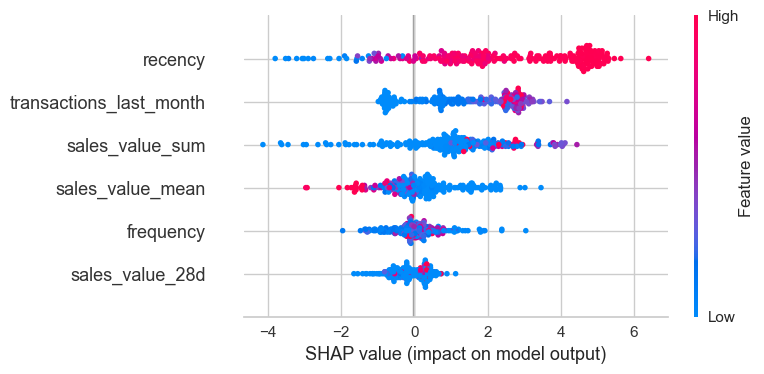

In [43]:
# Visualize the trained XGBoost Classification Model using SHAP for interpretation

clf.interpret_model(xgb_clf_model)

This visual interprets that "recency," followed by "transactions_last_month" are the most important features to predict future purchases. 

### XGBoost Regression

In [46]:
from pycaret.regression import *

In [120]:
# Setup the XGBoost Regression Model using PyCaret

reg_setup = setup(
    data = features_df.drop('sales_90_flag', axis = 1),
    target = 'Sales_90d',
    train_size = 0.7,
    normalize = True,
    session_id = 42,
    verbose = True,
    log_experiment = False
)

,Description,Value
0,Session id,42
1,Target,Sales_90d
2,Target type,Regression
3,Original data shape,"(2495, 7)"
4,Transformed data shape,"(2495, 7)"
5,Transformed train set shape,"(1746, 7)"
6,Transformed test set shape,"(749, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [122]:
# Initialize the machine learning regression setup using PyCaret

reg_setup = setup(data=features_df, target='Sales_90d', ignore_features=[])

# Create an XGBoost model

xgb_reg_model = create_model('xgboost')


,Description,Value
0,Session id,1309
1,Target,Sales_90d
2,Target type,Regression
3,Original data shape,"(2495, 8)"
4,Transformed data shape,"(2495, 8)"
5,Transformed train set shape,"(1746, 8)"
6,Transformed test set shape,"(749, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,442320.4688,2832396976128.0000,1682972.6250,0.5208,5.2460,829.9760
1,257161.5156,473549864960.0000,688149.6250,0.5286,5.6048,877.7946
2,347653.5625,1050359103488.0000,1024870.3125,-0.3896,5.1324,576.4233
3,294434.2812,504730648576.0000,710444.0000,0.3453,5.3204,864.7006
4,375417.5938,847146713088.0000,920405.7500,0.5506,5.2238,457.9330
5,573947.8750,3156059357184.0000,1776530.1250,0.2364,5.2176,866.9532
6,331689.4688,537642467328.0000,733241.0625,0.5579,5.8449,3303.7007
7,353707.3438,498482216960.0000,706032.7500,0.4019,5.6150,644.3995
8,382794.8125,889002721280.0000,942869.4375,0.5021,5.3136,1028.2155


In [123]:
# Generate predictions using the trained XGBoost Regression Model

reg_predictions_df = predict_model(xgb_reg_model, data = features_df).sort_values('prediction_label', ascending = False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,116562.4453,127902916608.0000,357635.1875,0.9270,4.7090,522.4654


The model explains 92.7% of variability, which is slightly overpredicted. 

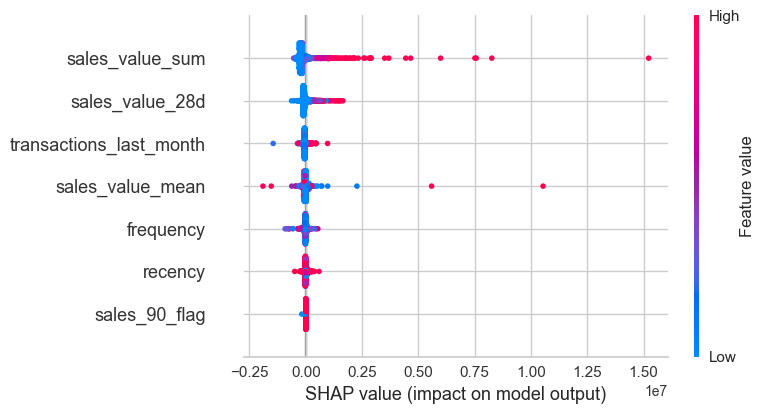

In [51]:
# Visualize the trained XGBoost Regression Model using SHAP for interpretation

interpret_model(xgb_reg_model)

This visual interprets that the "sales_value_sum," followed by "sales_value_28d" is the most important feature for predicting future purchase.

In [53]:
reg_predictions_df

,recency,frequency,sales_value_sum,sales_value_mean,transactions_last_month,sales_value_28d,sales_90_flag,Sales_90d,prediction_label
CustomerID,,,,,,,,,
cust755,0,431,39401712.00,91419.28,14.00,9200689.00,1,28430536.00,28403756.00
cust2219,-10,46,17515282.00,380767.00,3.00,2724227.25,1,5090506.50,24950676.00
cust2115,0,1022,20465884.00,20025.33,15.00,2178621.50,1,14060932.00,14051176.00
cust1730,0,70,10866836.00,155240.52,6.00,879710.38,1,3059634.00,13878844.00
cust588,0,641,835417.44,1303.30,12.00,431.91,1,11862665.00,11488752.00
...,...,...,...,...,...,...,...,...,...
cust2311,-1,206,1133315.00,5501.53,4.00,101.89,1,1292035.50,-195658.62
cust793,-2,108,1446592.50,13394.38,6.00,43.10,1,157.36,-223366.75
cust1031,-30,481,4548166.00,9455.65,0.00,0.00,0,0.00,-331742.97


In [54]:
# Compute the total predicted revenue across all customers for the next 90 days

pred_sum = reg_predictions_df['prediction_label'].sum()
print(pred_sum)

992772000.0


The regression model predicts that the total sales for the next 90 days will be over $992.8M. Based on historical data, this is probable and highly likely.

# Summary and Next Steps

### Model Results

In [58]:
annual_sales = pred_sum * 1.10 * 4

quarter_sales = pred_sum * 1.1

print(annual_sales)
print(quarter_sales)

print(quarter_sales - pred_sum)

4368196659.200001
1092049164.8000002
99277196.80000019


If total sales grew by an additional 10% over the predicted amount for one year, Annual Sales would equal $4.63B.

If total sales grew by an additional 10% over the predicted amount for 90 days, sales would be $105.2M higher than the original prediction. 

Our models indicate total sales and recency are the two most important factors for determining sales. To increase sales by 10%, focus on the top customer set, based on their predicted sales, and the most frequently purchased products by those customers. 

In [60]:
# List the Top 20 customers based on predicted sales

top_20_customers = reg_predictions_df.head(20).index.to_list()

print(top_20_customers)

['cust755', 'cust2219', 'cust2115', 'cust1730', 'cust588', 'cust1609', 'cust289', 'cust13', 'cust1527', 'cust707', 'cust1091', 'cust58', 'cust1166', 'cust1430', 'cust653', 'cust1314', 'cust1770', 'cust2322', 'cust2097', 'cust426']


In [61]:
# List the 5 most frequently purchased products among the Top 20 customers

top_products = df \
    .query('CustomerID in @top_20_customers') \
    .groupby('ProductID') \
    .size() \
    .to_frame() \
    .set_axis(['count'], axis = 1) \
    .sort_values('count', ascending = False)

top_products.head(5)

,count
ProductID,
6534178,677
1082185,311
1029743,263
951590,168
1127831,106


In [62]:
# Identify the top-selling products among the Top 20 customers

df[['CustomerID', 'ProductID', 'Sales']].query('CustomerID in @top_20_customers').groupby('ProductID').sum().sort_values('Sales', ascending = False)

,Sales
ProductID,
6534178,390301832.03
6533889,45929272.03
6534166,22647961.97
6544236,8032028.57
5668996,1178647.20
...,...
9526699,0.00
6424259,0.00
9485312,0.00


### Next Steps

There are various opportunities for further utilizing these findings, optimizing strategies and enhancing promotional capabilities. A few of these may include:

- Use A/B testing or multi-variate testing to gather performance based on our top customer and product lists.
- Optimize Marketing Mix Model (MMM) to increase frequency and recency. Predicting an optimal MMM increases ROI and validates the additional investment to increase frequency and recency.